In [1]:
!pip install pyLDAvis
!pip install sentence-transformers scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.9 MB/s eta 0:00:00


In [3]:
# Download NLTK packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import re
import seaborn as sns

from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4

In [51]:
drive.mount('/content/drive')

data = pd.read_excel('/content/drive/MyDrive/Manufactured Ecosystems/soil formation/soil formation.xlsx')
data = pd.DataFrame(data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

Feature Engineering, combine suitability and confidence score as composite score where high score means high suitablity **AND** high confidence level. Low score means low suitability **OR** low confidence level.

In [52]:
import pandas as pd
# Map Suitability Labels to Numerical Values
label_to_value = {"yes": 0.9, "maybe": 0.5, "no": 0.2}
data["Suitability"] = data["Suitability"].map(label_to_value)

# Compute Composite Score
data["Composite Score"] = data["Suitability"] * data["Confidence"]

# Output the DataFrame
print(data.head(5))

   Index       Authors                                       Article Title  \
0     39          Stavi  The potential use of biochar in reclaiming deg...   
1     83            Rao  Agricultural Microbiology Research Progress in...   
2      1       Quilliam  Life in the 'charosphere' - Does biochar in ag...   
3      8         Burges  From phytoremediation of soil contaminants to ...   
4     11  Gomez-Sagasti  Microbial Monitoring of the Recovery of Soil Q...   

   Publication Year                                           Abstract  \
0              2012  Many of the world's rangelands are degraded du...   
1              2019  The research efforts in microbiology over last...   
2              2013  Biochar application has become a novel and eme...   
3              2018  Since the emergence of phytoremediation, much ...   
4              2012  Soil pollution with heavy metals is a worldwid...   

   Suitability  Confidence           Keyword  Composite Score  
0          0.9        

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
# Preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Lowercase, remove special characters
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Tokenize
    words = nltk.word_tokenize(text)

    # Remove stopwords and lemmatize
    processed = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return processed

# Load abstracts
abstracts = data['Abstract']
keywords = data['Keyword']
# Preprocess all abstracts
preprocessed_abstracts = [preprocess_text(abstract) for abstract in abstracts]
preprocessed_keywords = [preprocess_text(keyword) for keyword in keywords]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LDA

## Optimal Topic Number

In [54]:
# Create a dictionary representation of the documents
dictionary = Dictionary(preprocessed_abstracts)

# Convert the documents into a bag-of-words format
corpus = [dictionary.doc2bow(text) for text in preprocessed_abstracts]

print("Sample BOW representation:", corpus[:1])  # Example output

Sample BOW representation: [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, 4), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 3), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 6), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1)]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


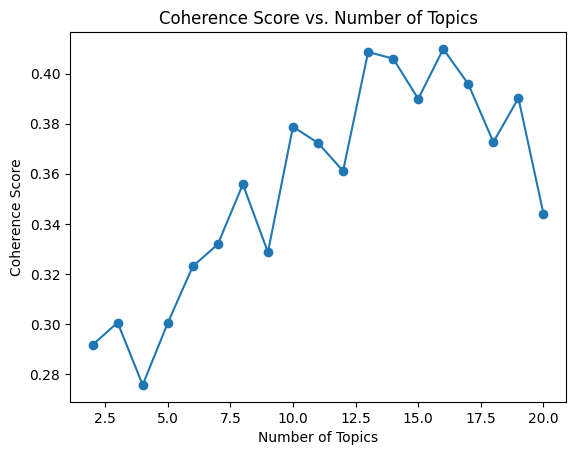

In [55]:
# Function to compute coherence scores for different topic numbers
def find_optimal_topics(corpus, dictionary, texts, start=2, end=20):
    coherence_scores = []
    for num_topics in range(start, end + 1):
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append((num_topics, coherence_model.get_coherence()))
    return coherence_scores

# Compute coherence scores
coherence_scores = find_optimal_topics(corpus, dictionary, preprocessed_abstracts)

# Plot the coherence scores
import matplotlib.pyplot as plt
x, y = zip(*coherence_scores)
plt.plot(x, y, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

In [56]:
# Number of topics to extract
num_topics = 13

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=89)

# Print the topics
topics = lda_model.print_topics(num_words=10)
for topic_num, topic in topics:
    print(f"Topic {topic_num+1}: {topic}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1: 0.010*"wastewater" + 0.009*"soil" + 0.009*"ec" + 0.008*"biomass" + 0.008*"process" + 0.008*"chemical" + 0.008*"environment" + 0.007*"however" + 0.006*"concentration" + 0.006*"ch"
Topic 2: 0.018*"biochar" + 0.010*"soil" + 0.009*"microbial" + 0.008*"sediment" + 0.006*"test" + 0.006*"capital" + 0.005*"environmental" + 0.005*"energy" + 0.005*"ecological" + 0.005*"variable"
Topic 3: 0.023*"soil" + 0.016*"carbon" + 0.011*"ca" + 0.009*"land" + 0.009*"c" + 0.008*"storage" + 0.008*"x" + 0.007*"practice" + 0.007*"service" + 0.007*"ecosystem"
Topic 4: 0.013*"earthworm" + 0.012*"soil" + 0.008*"straw" + 0.008*"specie" + 0.007*"crop" + 0.007*"n" + 0.007*"rhizosphere" + 0.007*"cocropping" + 0.005*"organic" + 0.005*"hydrosols"
Topic 5: 0.041*"soil" + 0.012*"ecosystem" + 0.009*"service" + 0.008*"microbial" + 0.007*"study" + 0.007*"wetland" + 0.007*"change" + 0.007*"plant" + 0.007*"value" + 0.006*"forest"
Topic 6: 0.023*"soil" + 0.009*"food" + 0.009*"crop" + 0.008*"land" + 0.006*"ecosystem" + 0

## Compare with LLM Keywords

In [57]:
# Function to calculate Jaccard similarity
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    return len(set1 & set2) / len(set1 | set2)

def preprocess_keywords(keywords):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Preprocess LLM keywords
    processed_keywords = [
        lemmatizer.lemmatize(word.lower())
        for word in keywords if word.lower() not in stop_words
    ]
    return processed_keywords

processed_keywords = preprocess_keywords(keywords)

# Compare LDA topics with LLM keywords
for topic_num, topic in topics:
    lda_keywords = [term.split('*')[1].strip('"') for term in topic.split('+')]
    similarity = jaccard_similarity(processed_keywords, lda_keywords)
    print(f"Jaccard Similarity with Topic {topic_num+1}: {similarity}")

Jaccard Similarity with Topic 1: 0.0
Jaccard Similarity with Topic 2: 0.0
Jaccard Similarity with Topic 3: 0.0
Jaccard Similarity with Topic 4: 0.0
Jaccard Similarity with Topic 5: 0.0
Jaccard Similarity with Topic 6: 0.0
Jaccard Similarity with Topic 7: 0.0
Jaccard Similarity with Topic 8: 0.0
Jaccard Similarity with Topic 9: 0.011764705882352941
Jaccard Similarity with Topic 10: 0.0
Jaccard Similarity with Topic 11: 0.0
Jaccard Similarity with Topic 12: 0.0
Jaccard Similarity with Topic 13: 0.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all LDA topic terms and LLM keywords into one list
all_terms = [' '.join(lda_keywords), ' '.join(keywords)]

# Compute TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_terms)

# Compute cosine similarity between LDA and LLM terms
cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
print("TF-IDF Cosine Similarity:", cosine_sim[0][0])

TF-IDF Cosine Similarity: 0.3599807430025017


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
# Identify contributing keywords
feature_names = vectorizer.get_feature_names_out()
lda_vector = tfidf_matrix[0].toarray().flatten()
llm_vector = tfidf_matrix[1].toarray().flatten()

# Match terms with their TF-IDF weights
term_weights = [(feature_names[i], lda_vector[i], llm_vector[i]) for i in range(len(feature_names))]

# Filter terms where both vectors have non-zero weights
common_terms = [(term, lda_weight, llm_weight) for term, lda_weight, llm_weight in term_weights if lda_weight > 0 and llm_weight > 0]
print("Common Terms with TF-IDF Weights:", common_terms)

Common Terms with TF-IDF Weights: [('carbon', 0.278142902822662, 0.25884589493337984), ('ecosystem', 0.278142902822662, 0.23008523994078206), ('irrigation', 0.278142902822662, 0.028760654992597758), ('organic', 0.278142902822662, 0.057521309985195515), ('service', 0.278142902822662, 0.08628196497779328), ('soil', 0.278142902822662, 0.5752130998519551), ('water', 0.278142902822662, 0.057521309985195515)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Semantic Similarity Analysis

In [60]:
# Initialize the Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

abstracts = data['Abstract']
keywords = data['Keyword']

# Generate embeddings for abstracts and LLM keywords
abstract_embeddings = model.encode(abstracts)
keywords_embeddings = model.encode(keywords)

# Compute cosine similarity between each abstract and its corresponding LLM keywords
similarities = [cosine_similarity([abstract_embeddings[i]], [keywords_embeddings[i]])[0][0] for i in range(len(abstracts))]

# Display similarity scores
for i, similarity in enumerate(similarities):
    print(f"Abstract {i+1} - Semantic Similarity: {similarity:.4f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Abstract 1 - Semantic Similarity: 0.4177
Abstract 2 - Semantic Similarity: 0.7016
Abstract 3 - Semantic Similarity: 0.5078
Abstract 4 - Semantic Similarity: 0.6526
Abstract 5 - Semantic Similarity: 0.4250
Abstract 6 - Semantic Similarity: 0.7636
Abstract 7 - Semantic Similarity: 0.7453
Abstract 8 - Semantic Similarity: 0.4913
Abstract 9 - Semantic Similarity: 0.5895
Abstract 10 - Semantic Similarity: 0.5958
Abstract 11 - Semantic Similarity: 0.6644
Abstract 12 - Semantic Similarity: 0.6235
Abstract 13 - Semantic Similarity: 0.4854
Abstract 14 - Semantic Similarity: 0.6737
Abstract 15 - Semantic Similarity: 0.6072
Abstract 16 - Semantic Similarity: 0.3439
Abstract 17 - Semantic Similarity: 0.6898
Abstract 18 - Semantic Similarity: 0.5172
Abstract 19 - Semantic Similarity: 0.3692
Abstract 20 - Semantic Similarity: 0.5300
Abstract 21 - Semantic Similarity: 0.6745
Abstract 22 - Semantic Similarity: 0.4797
Abstract 23 - Semantic Similarity: 0.4724
Abstract 24 - Semantic Similarity: 0.4912
A

In [61]:
# Save Results
data['Semantic Similarity'] = similarities

output_file = 'output.xlsx'
data.to_excel(output_file, index=False)

print(f"Results saved to {output_file}")

Results saved to output.xlsx


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
